# Penguin classification based on flipper and bill length

In [239]:
# import dependencies
from palmerpenguins import load_penguins
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import requests
from pathlib import Path
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay

In [317]:
df = load_penguins()
to_colors = {'Adelie':0,
             'Gentoo':1,
             'Chinstrap':2}
df = df[df['bill_length_mm'].notna()]
df = (df.replace({"species": to_colors}))
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,0,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,0,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,0,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,0,Torgersen,39.3,20.6,190.0,3650.0,male,2007


tensor([[-0.8832, -1.4163],
        [-0.8099, -1.0607],
        [-0.6634, -0.4207],
        [-1.3228, -0.5629],
        [-0.8466, -0.7762]]) tensor([0, 0, 0, 0, 0])


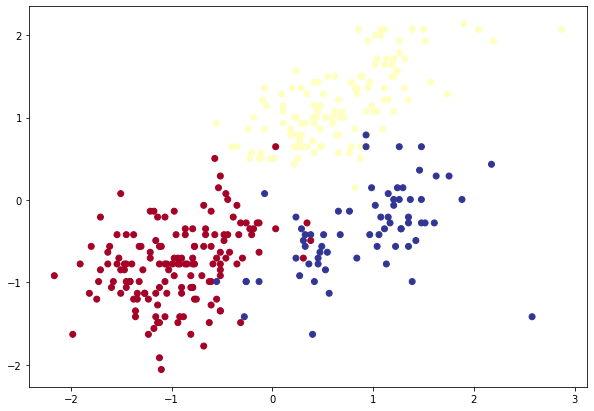

In [318]:
NUM_CLASSES = 3
NUM_FEATURES = 2
RANDOM_SEED = 42

df['bill_length_mm']=(df['bill_length_mm']-df['bill_length_mm'].mean())/df['bill_length_mm'].std()
df['flipper_length_mm']=(df['flipper_length_mm']-df['flipper_length_mm'].mean())/df['flipper_length_mm'].std()
X_blob = df[['bill_length_mm','flipper_length_mm']].to_numpy()
y_blob = df['species'].to_numpy()

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [319]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [320]:
# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [321]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1)

In [322]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
print(X_blob_train.type())
model_4(X_blob_train.to(device))[:5]

torch.FloatTensor


tensor([[-0.0324, -0.2569, -0.0459],
        [ 0.3700, -0.2398,  0.4003],
        [ 0.2755, -0.1592,  0.3077],
        [-0.3989, -0.3042, -0.4567],
        [ 0.0900, -0.1731,  0.1013]], grad_fn=<SliceBackward0>)

In [324]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([3]), 3)

In [325]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.1646, -0.4668, -0.2219],
        [ 0.1979, -0.2929,  0.2029],
        [ 0.1305, -0.2132,  0.1401],
        [-0.0957, -0.2550, -0.1154],
        [ 0.0264, -0.2489,  0.0201]], grad_fn=<SliceBackward0>)
tensor([[0.3726, 0.2755, 0.3519],
        [0.3821, 0.2339, 0.3840],
        [0.3678, 0.2608, 0.3714],
        [0.3529, 0.3010, 0.3461],
        [0.3632, 0.2758, 0.3610]], grad_fn=<SliceBackward0>)


In [326]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [327]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3726, 0.2755, 0.3519], grad_fn=<SelectBackward0>)
tensor(0)


In [328]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.08213, Acc: 16.48% | Test Loss: 1.02790, Test Acc: 69.57%
Epoch: 10 | Loss: 0.67519, Acc: 78.39% | Test Loss: 0.65327, Test Acc: 82.61%
Epoch: 20 | Loss: 0.48829, Acc: 78.39% | Test Loss: 0.46556, Test Acc: 82.61%
Epoch: 30 | Loss: 0.41186, Acc: 82.05% | Test Loss: 0.38307, Test Acc: 85.51%
Epoch: 40 | Loss: 0.35591, Acc: 86.08% | Test Loss: 0.32638, Test Acc: 88.41%
Epoch: 50 | Loss: 0.30082, Acc: 91.94% | Test Loss: 0.27588, Test Acc: 92.75%
Epoch: 60 | Loss: 0.24956, Acc: 94.87% | Test Loss: 0.23284, Test Acc: 95.65%
Epoch: 70 | Loss: 0.20910, Acc: 94.87% | Test Loss: 0.20165, Test Acc: 97.10%
Epoch: 80 | Loss: 0.18095, Acc: 94.87% | Test Loss: 0.18151, Test Acc: 95.65%
Epoch: 90 | Loss: 0.16227, Acc: 94.87% | Test Loss: 0.16872, Test Acc: 95.65%


In [329]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-1.3562,  2.9254, -2.2434],
        [ 3.6893, -0.4753, -2.0227],
        [ 3.1258, -1.9566, -0.4234],
        [ 0.1998, -1.0910,  0.4143],
        [ 1.7236, -1.2469, -0.2793],
        [-3.0577, -1.1508,  2.2399],
        [-0.2303,  1.2913, -1.4304],
        [-3.3000,  1.4188,  0.1295],
        [-2.5720, -1.6935,  2.4490],
        [ 3.2801, -3.4247,  0.7737]])

In [330]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 0, 0, 2, 0, 2, 1, 1, 2, 0])
Labels: tensor([1, 0, 0, 0, 0, 2, 1, 1, 2, 0])
Test accuracy: 95.65217391304348%


In [331]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

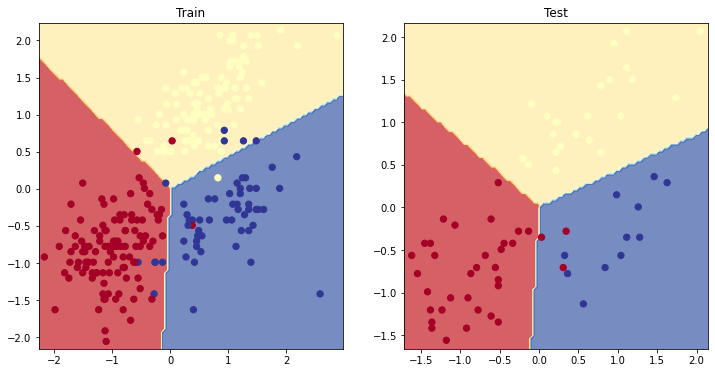

In [332]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)